In [4]:
import sys
sys.path.append("/root/sae-data-selection/SAELens/")
from datasets import load_dataset
from transformer_lens import utils, HookedTransformer
import gc
import torch
from less.jacob.load_sae_from_hf import load_sae_from_hf
from sae_lens.config import DTYPE_MAP
from tqdm import tqdm
import pandas as pd
import plotly.express as px

torch.set_grad_enabled(False)

# Set params

In [5]:
# Set these variables
DTYPE = "bfloat16"

model_name = "gemma-2b-it"

owt_path = "stas/openwebtext-10k"
owt_split = "train"
owt_num_batches = 20_000

spec_path = "jacobcd52/physics-papers"
spec_split = "train[:10%]"
spec_num_batches = 20_000

In [6]:
# Set these HF file paths
gsae = load_sae_from_hf("jacobcd52/gemma2-gsae", 
                        "sae_weights.safetensors", 
                        "cfg.json",
                        device="cuda", dtype=DTYPE)
ssae_list = [
    load_sae_from_hf("jacobcd52/gemma2-ssae-phys",
                    f"l1_coeff={l1_coeff}_tokens=40960000_lr=0.001.safetensors",
                    f"l1_coeff={l1_coeff}_tokens=40960000_lr=0.001_cfg.json",
                    device="cuda", dtype=DTYPE)
    for l1_coeff in [5, 10, 20]]
gsae_ft_list = [
    load_sae_from_hf("jacobcd52/gemma2-gsae-finetune-phys",
                    f"l1_coeff={l1_coeff}_tokens=10240000_lr=0.0001.safetensors",
                    f"l1_coeff={l1_coeff}_tokens=10240000_lr=0.0001_cfg.json",
                    device="cuda", dtype=DTYPE)
    for l1_coeff in [1, 2, 5]]

sae_weights.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

cfg.json:   0%|          | 0.00/786 [00:00<?, ?B/s]

(…)oeff=5_tokens=40960000_lr=0.001_cfg.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

(…)eff=10_tokens=40960000_lr=0.001_cfg.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

(…)eff=20_tokens=40960000_lr=0.001_cfg.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

(…)eff=1_tokens=10240000_lr=0.0001_cfg.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

(…)eff=2_tokens=10240000_lr=0.0001_cfg.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

(…)eff=5_tokens=10240000_lr=0.0001_cfg.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

# Setup

In [2]:
all_ctx_lengths = [gsae.cfg.context_size] + [sae.cfg.context_size for sae in ssae_list + gsae_ft_list]
ctx_length = min(all_ctx_lengths)
print("context length =", ctx_length)

all_hook_pts = set([gsae.cfg.hook_name] + [sae.cfg.hook_name for sae in ssae_list + gsae_ft_list])
assert len(all_hook_pts) == 1, "All models must have the same hook point"
hook_pt = all_hook_pts.pop()
print("hook point =", hook_pt)

NameError: name 'gsae' is not defined

In [ ]:
model = HookedTransformer.from_pretrained_no_processing(model_name, device="cuda", dtype=DTYPE)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b-it into HookedTransformer


In [ ]:
# Get owt tokens
data = load_dataset(owt_path, split=owt_split)
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=ctx_length)
tokenized_data = tokenized_data.shuffle(42)
owt_tokens = tokenized_data["tokens"][:owt_num_batches].cuda()
print("owt_tokens has shape", owt_tokens.shape)
print("total number of tokens:", int(owt_tokens.numel()//1e6), "million")
print()

# Get speciaized tokens
data = load_dataset(spec_path, split=spec_split)
# Use filter function to remove null entries
def remove_null_entries(example):
    return all(value is not None and value != '' for value in example.values())
data = data.filter(remove_null_entries)
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=ctx_length)
tokenized_data = tokenized_data.shuffle(42)
spec_tokens = tokenized_data["tokens"][:spec_num_batches].cuda()
print("spec_tokens has shape", spec_tokens.shape)
print("total number of tokens:", int(spec_tokens.numel()//1e6), "million")

# clean up
del tokenized_data, data
gc.collect()

owt_tokens has shape torch.Size([20000, 128])
total number of tokens: 2 million

spec_tokens has shape torch.Size([20000, 128])
total number of tokens: 2 million


0

In [ ]:
def to_str(i):
    if i ==0: 
        return "gsae"
    elif i == 1:
        return "ssae"
    else:
        print("sae_list too large")


def get_l0_freqs_loss_fvu(
        sae_list,  # "clean" or [gsae] or [gsae, ssae]
        tokens, 
        num_tokens = 100_000, 
        batch_size=128
        ):
    '''Computes L0, feature frequencies, the patched CE loss, and the Fraction of Variance Unexplained (FVU) for a given list of SAEs.
    The outputs of SAEs in the list are summed when patching.'''
    
    # Initialize running variables
    total_fvu = {'all_saes' : 0}
    if sae_list != "clean":
        total_freqs = {i : torch.zeros(sae.cfg.d_sae).cuda() 
                for i, sae in enumerate(sae_list)}
    else:
        total_freqs = {}
    total_loss = 0
    
    # define hook fn to patch in SAE reconstructions, as well as cache the FVU and L0
    def patch_hook(act, hook):              
        # option to run the model clean
        if sae_list == "clean":
            return act
        # patch in SAE reconstructions
        else:
            out = torch.zeros_like(act)
            for i, sae in enumerate(sae_list):
                feature_acts = sae.encode_fn(act)
                total_freqs[i] += (feature_acts > 0).float()[:, 1:].mean([0,1])
                out += sae.decode(feature_acts)

            total_fvu['all_saes'] += ((out - act).pow(2)[:,1:].sum() / (act - act.mean(0)).pow(2)[:,1:].sum()).item()
            return out

    num_batches = num_tokens // (tokens.shape[1] * batch_size)

    for b in tqdm(range(num_batches)):
        # get batch
        batch = tokens[b*batch_size:(b+1)*batch_size]
        loss = model.run_with_hooks(
            batch,
            return_type="loss",
            loss_per_token=True,
            fwd_hooks = [(hook_pt, patch_hook)]
        )[:,1:].mean()
        total_loss += loss.item()
    
    freqs = {to_str(i) : count / num_batches for i, count in total_freqs.items()}
    l0 = sum([freqs.sum() for _, freqs in freqs.items()])
    return  l0, freqs, total_loss / num_batches, total_fvu['all_saes'] / num_batches

In [ ]:
def sweep(list_of_sae_lists, 
        tokens, 
        ceiling_loss, 
        clean_loss, 
        ceiling_fvu,
        num_tokens = 100_000):
    l0_list = []
    freqs_list = []
    score_list = []
    fvu_recovered_list = []
    
    for sae_list in tqdm(list_of_sae_lists):
        l0, freqs, loss, fvu = get_l0_freqs_loss_fvu(sae_list, tokens, num_tokens=num_tokens)
        l0_list.append(l0)

        # compute loss recovered score
        score = (ceiling_loss - loss) / (ceiling_loss - clean_loss)
        score_list.append(score)

        # compute variance explained
        fvu_recovered = (ceiling_fvu - fvu) / ceiling_fvu
        fvu_recovered_list.append(fvu_recovered)

        freqs_list.append(freqs)
        
    return l0_list, freqs_list, score_list, fvu_recovered_list

# Get Pareto frontiers & frequencies

In [ ]:
# Sanity check: the GSAE error should be smaller than the original activation
loss, cache = model.run_with_cache(
    "Hi, my name is Jacob, and I come from the city of London, England.",
    return_type="loss",
    names_filter=[hook_pt])
act = cache[hook_pt]
print(f"GSAE error norm = {(gsae(act) - act).norm().item():.1f}")
print(f"Input act norm = {act.norm().item():.1f}")

GSAE error norm = 41.2
Input act norm = 692.0


In [ ]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

# Get floor and ceiling losses, where we don't need to sweep
_, _, clean_owt_loss, _ = get_l0_freqs_loss_fvu("clean", owt_tokens)
_, _, clean_spec_loss, _ = get_l0_freqs_loss_fvu("clean", spec_tokens)
gsae_owt_l0, gsae_owt_freqs, gsae_owt_loss, gsae_owt_fvu = get_l0_freqs_loss_fvu([gsae], owt_tokens)
gsae_phys_l0, gsae_phys_freqs, gsae_spec_loss, gsae_spec_fvu = get_l0_freqs_loss_fvu([gsae], spec_tokens)

print(f"clean owt loss = {clean_owt_loss:.3f}")
print(f"clean spec loss = {clean_spec_loss:.3f}")
print()
print(f"gsae owt loss = {gsae_owt_loss:.3f}")
print(f"gsae spec loss = {gsae_spec_loss:.3f}")
print()
print(f"gsae owt L0 = {gsae_owt_l0:.1f}")
print(f"gsae spec L0 = {gsae_phys_l0:.1f}")
print()
print(f"gsae owt FVU = {gsae_owt_fvu:.2f}")
print(f"gsae spec FVU = {gsae_spec_fvu:.2f}")

100%|██████████| 6/6 [00:09<00:00,  1.52s/it]

clean owt loss = 4.078
clean spec loss = 4.266

gsae owt loss = 4.141
gsae spec loss = 4.740

gsae owt L0 = 21.2
gsae spec L0 = 22.3

gsae owt FVU = 0.38
gsae spec FVU = 0.50


In [ ]:
num_tokens = 1_000_000
# get pareto data for SSAEs
list_of_sae_lists = [[gsae, ssae] for ssae in ssae_list]
ssae_owt_l0, ssae_owt_freqs, ssae_owt_scores, ssae_owt_fvu_recovered = sweep(list_of_sae_lists, owt_tokens, gsae_owt_loss, clean_owt_loss, gsae_owt_fvu, num_tokens=num_tokens)
ssae_spec_l0, ssae_spec_freqs, ssae_spec_scores, ssae_spec_fvu_recovered = sweep(list_of_sae_lists, spec_tokens, gsae_spec_loss, clean_spec_loss, gsae_spec_fvu, num_tokens=num_tokens)

# get pareto data for GSAE finetunes
list_of_sae_lists = [[gsae] for gsae in gsae_ft_list]
gsae_ft_owt_l0, gsae_ft_owt_freqs, gsae_ft_owt_scores, gsae_ft_owt_fvu_recovered = sweep(list_of_sae_lists, owt_tokens, gsae_owt_loss, clean_owt_loss, gsae_owt_fvu, num_tokens=num_tokens)
gsae_ft_spec_l0, gsae_ft_spec_freqs, gsae_ft_spec_scores, gsae_ft_spec_fvu_recovered = sweep(list_of_sae_lists, spec_tokens, gsae_spec_loss, clean_spec_loss, gsae_spec_fvu, num_tokens=num_tokens)

100%|██████████| 3/3 [04:39<00:00, 93.21s/it]


In [ ]:
# Create a DataFrame for each set of data
df_ssae = pd.DataFrame({'l0': ssae_owt_l0, 'Scores': ssae_owt_fvu_recovered, 'Type': 'SSAE'})
df_gsae_ft = pd.DataFrame({'l0': gsae_ft_owt_l0, 'Scores': gsae_ft_owt_fvu_recovered, 'Type': 'GSAE Finetune'})

# Combine the DataFrames
df = pd.concat([df_ssae, df_gsae_ft])

# Create a line plot
fig = px.line(df, x='l0', y='Scores', color='Type', labels={'l0': 'l0', 'Scores': 'Scores'}, title='OWT Pareto Frontiers')

# Show the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [ ]:
# Create a DataFrame for each set of data
df_ssae = pd.DataFrame({'l0': ssae_spec_l0, 'Scores': ssae_spec_fvu_recovered, 'Type': 'SSAE'})
df_gsae_ft = pd.DataFrame({'l0': gsae_ft_spec_l0, 'Scores': gsae_ft_spec_fvu_recovered, 'Type': 'GSAE Finetune'})

# Combine the DataFrames
df = pd.concat([df_ssae, df_gsae_ft])

# Create a line plot
fig = px.line(df, x='l0', y='Scores', color='Type', labels={'l0': 'l0', 'Scores': 'Scores'}, title='specialized dataset Pareto Frontiers')

# Show the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



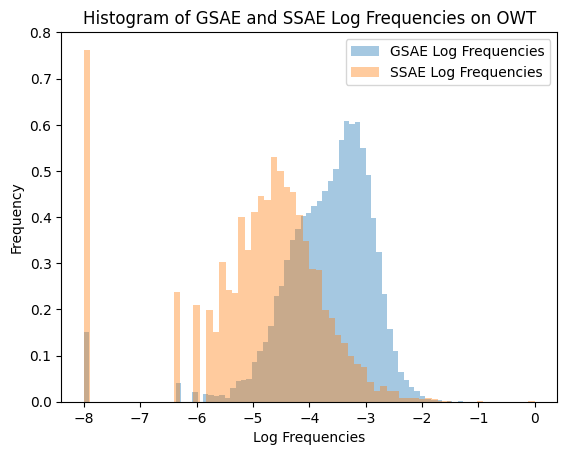

In [ ]:
import matplotlib.pyplot as plt

# choose sparsest SSAE and compare frequencies to GSAE
gsae_logfreqs = (ssae_owt_freqs[-1]['gsae'] + 1e-8).log10().cpu()
ssae_logfreqs = (ssae_owt_freqs[-1]['ssae'] + 1e-8).log10().cpu()

# Plotting the histograms
plt.hist(gsae_logfreqs.numpy(), bins=70, alpha=0.4, label='GSAE Log Frequencies', density=True)
plt.hist(ssae_logfreqs.numpy(), bins=70, alpha=0.4, label='SSAE Log Frequencies', density=True)

# Adding labels and title
plt.xlabel('Log Frequencies')
plt.ylabel('Frequency')
plt.title('Histogram of GSAE and SSAE Log Frequencies on OWT')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# choose sparsest SSAE and compare frequencies to GSAE
gsae_logfreqs = (ssae_spec_freqs[-1]['gsae'] + 1e-8).log10().cpu()
ssae_logfreqs = (ssae_spec_freqs[-1]['ssae'] + 1e-8).log10().cpu()

# Plotting the histograms
plt.hist(gsae_logfreqs.numpy(), bins=70, alpha=0.4, label='GSAE Log Frequencies', density=True)
plt.hist(ssae_logfreqs.numpy(), bins=70, alpha=0.4, label='SSAE Log Frequencies', density=True)

# Adding labels and title
plt.xlabel('Log Frequencies')
plt.ylabel('Frequency')
plt.title('Histogram of GSAE and SSAE Log Frequencies on specialized dataset')
plt.legend()

# Display the plot
plt.show()

# Cossims

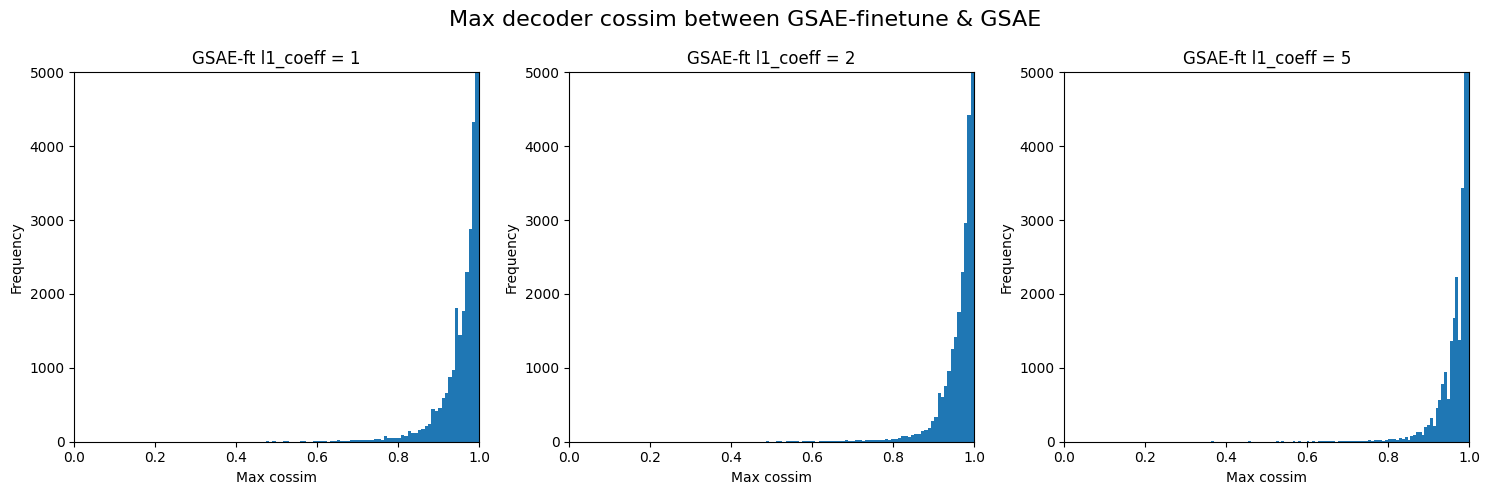

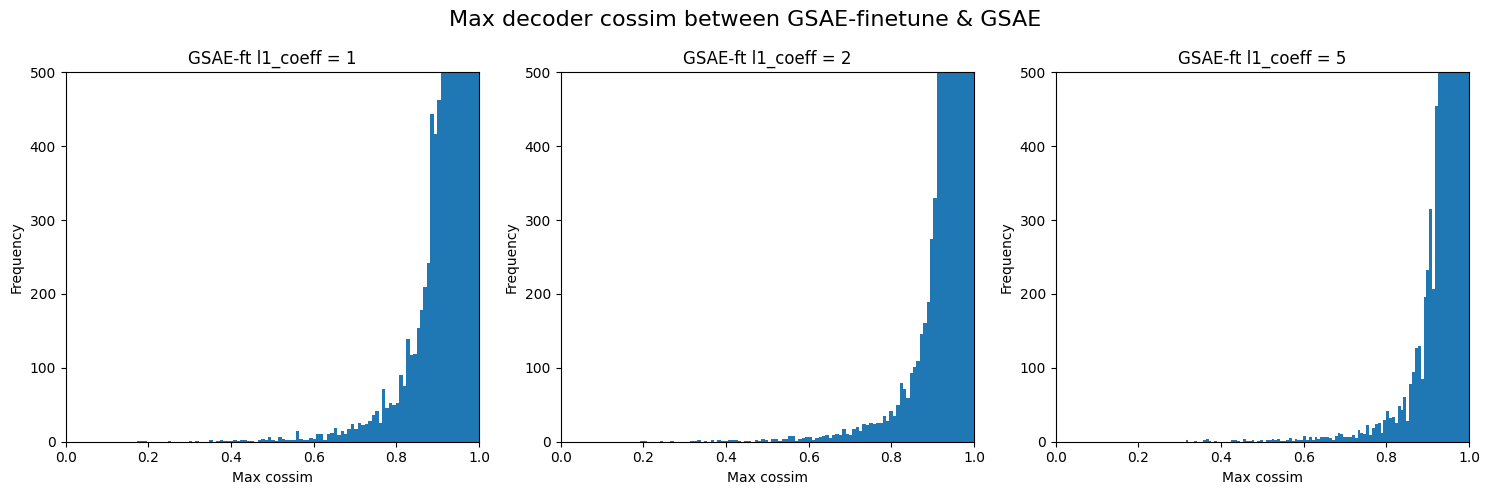

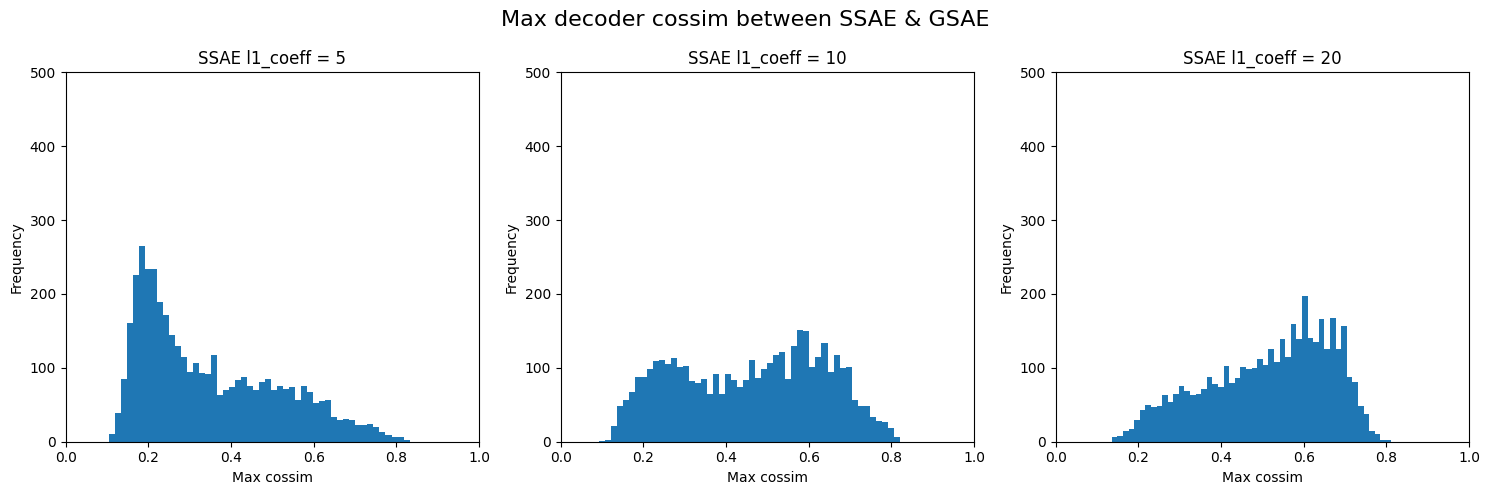

In [45]:
import matplotlib.pyplot as plt
# GSAE-ft
l1_coeffs = [1, 2, 5]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sae in enumerate(gsae_ft_list):
    gsae_W_dec = gsae.W_dec / gsae.W_dec.norm(dim=1, keepdim=True)
    sae_W_dec = sae.W_dec / sae.W_dec.norm(dim=1, keepdim=True)
    maxsims = (gsae_W_dec @ sae_W_dec.T).max(0).values.to(torch.float32).cpu().detach()
    
    # Select the current axis
    ax = axes[i]
    
    # Plot the histogram on the current axis
    ax.hist(maxsims, bins=100, alpha=1.0)
    ax.set_xlabel('Max cossim')
    ax.set_ylabel('Frequency')
    ax.set_title(f'GSAE-ft l1_coeff = {l1_coeffs[i]}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 5000])

fig.suptitle('Max decoder cossim between GSAE-finetune & GSAE', fontsize=16)

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()



# GSAE-ft ZOOMED
l1_coeffs = [1, 2, 5]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sae in enumerate(gsae_ft_list):
    gsae_W_dec = gsae.W_dec / gsae.W_dec.norm(dim=1, keepdim=True)
    sae_W_dec = sae.W_dec / sae.W_dec.norm(dim=1, keepdim=True)
    maxsims = (gsae_W_dec @ sae_W_dec.T).max(0).values.to(torch.float32).cpu().detach()
    
    # Select the current axis
    ax = axes[i]
    
    # Plot the histogram on the current axis
    ax.hist(maxsims, bins=100, alpha=1.0)
    ax.set_xlabel('Max cossim')
    ax.set_ylabel('Frequency')
    ax.set_title(f'GSAE-ft l1_coeff = {l1_coeffs[i]}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 500])

fig.suptitle('Max decoder cossim between GSAE-finetune & GSAE', fontsize=16)

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()


# SSAE
l1_coeffs = [5, 10, 20]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sae in enumerate(ssae_list):
    gsae_W_dec = gsae.W_dec / gsae.W_dec.norm(dim=1, keepdim=True)
    sae_W_dec = sae.W_dec / sae.W_dec.norm(dim=1, keepdim=True)
    maxsims = (gsae_W_dec @ sae_W_dec.T).max(0).values.to(torch.float32).cpu().detach()
    
    # Select the current axis
    ax = axes[i]
    
    # Plot the histogram on the current axis
    ax.hist(maxsims, bins=50, alpha=1.0)
    ax.set_xlabel('Max cossim')
    ax.set_ylabel('Frequency')
    ax.set_title(f'SSAE l1_coeff = {l1_coeffs[i]}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 500])

fig.suptitle('Max decoder cossim between SSAE & GSAE', fontsize=16)

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()

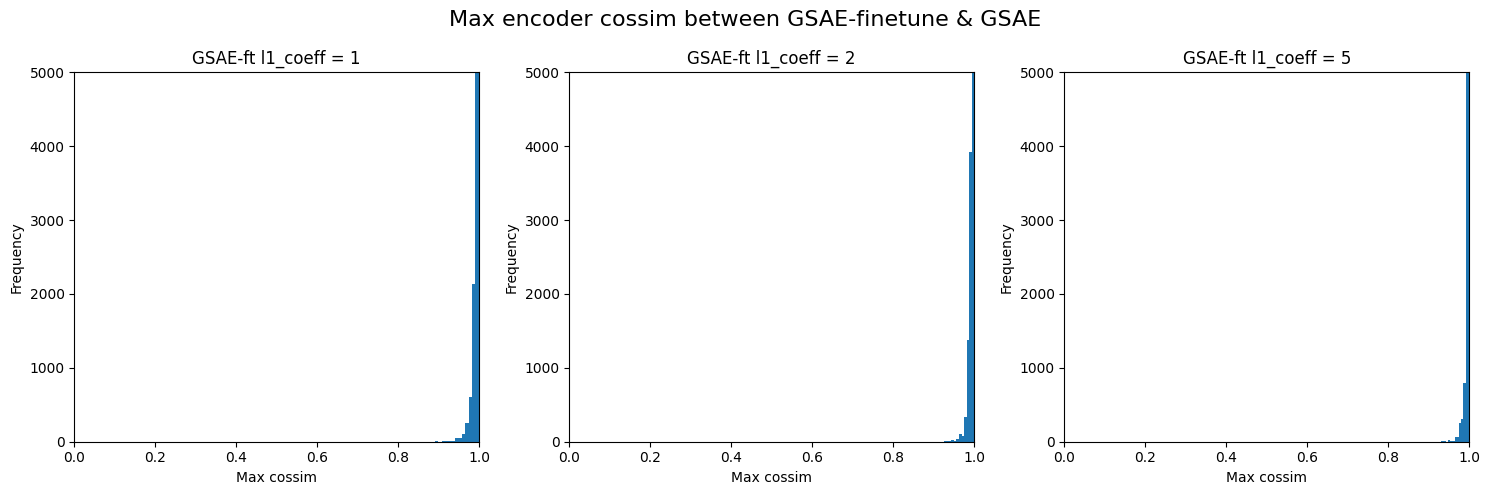

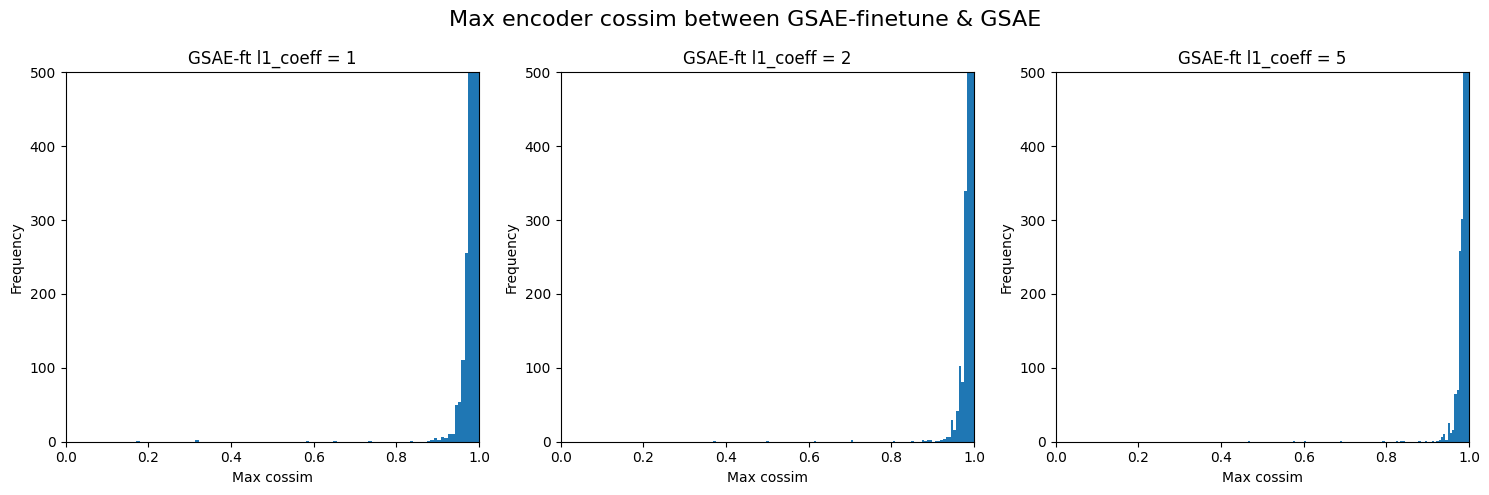

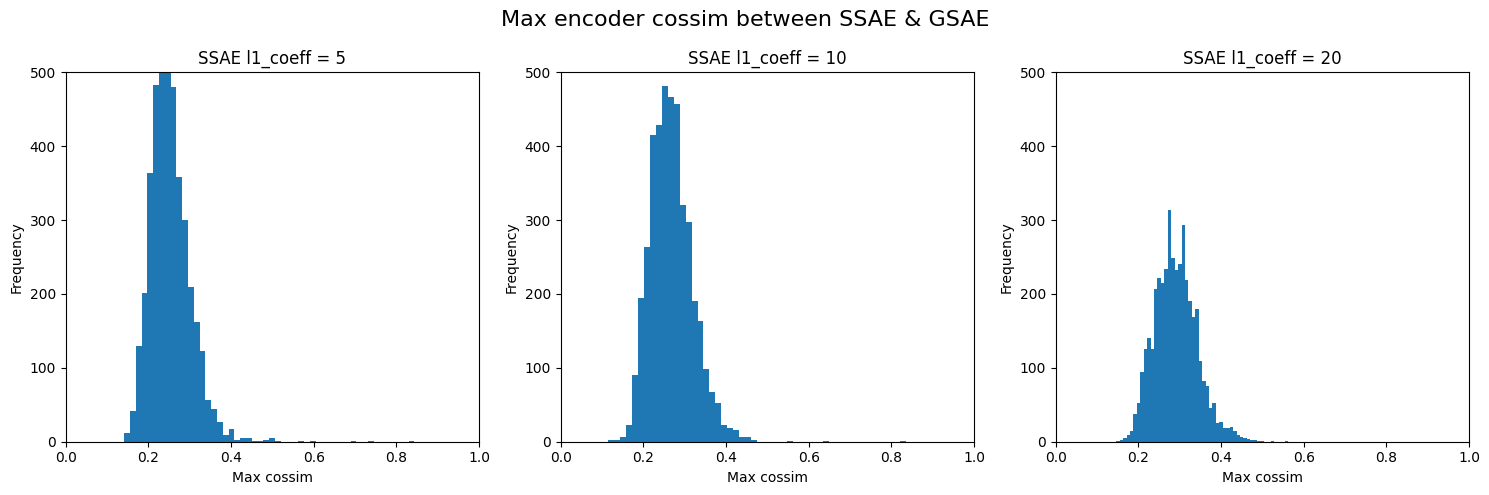

In [46]:
# GSAE-ft
l1_coeffs = [1, 2, 5]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sae in enumerate(gsae_ft_list):
    gsae_W_enc = gsae.W_enc / gsae.W_enc.norm(dim=0, keepdim=True)
    sae_W_enc = sae.W_enc / sae.W_enc.norm(dim=0, keepdim=True)
    maxsims = (gsae_W_enc.T @ sae_W_enc).max(0).values.to(torch.float32).cpu().detach()
    
    # Select the current axis
    ax = axes[i]
    
    # Plot the histogram on the current axis
    ax.hist(maxsims, bins=100, alpha=1.0)
    ax.set_xlabel('Max cossim')
    ax.set_ylabel('Frequency')
    ax.set_title(f'GSAE-ft l1_coeff = {l1_coeffs[i]}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 5000])

fig.suptitle('Max encoder cossim between GSAE-finetune & GSAE', fontsize=16)

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()



# GSAE-ft ZOOMED
l1_coeffs = [1, 2, 5]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sae in enumerate(gsae_ft_list):
    gsae_W_enc = gsae.W_enc / gsae.W_enc.norm(dim=0, keepdim=True)
    sae_W_enc = sae.W_enc / sae.W_enc.norm(dim=0, keepdim=True)
    maxsims = (gsae_W_enc.T @ sae_W_enc).max(0).values.to(torch.float32).cpu().detach()
    
    # Select the current axis
    ax = axes[i]
    
    # Plot the histogram on the current axis
    ax.hist(maxsims, bins=100, alpha=1.0)
    ax.set_xlabel('Max cossim')
    ax.set_ylabel('Frequency')
    ax.set_title(f'GSAE-ft l1_coeff = {l1_coeffs[i]}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 500])

fig.suptitle('Max encoder cossim between GSAE-finetune & GSAE', fontsize=16)

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()


# SSAE
l1_coeffs = [5, 10, 20]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sae in enumerate(ssae_list):
    gsae_W_enc = gsae.W_enc / gsae.W_enc.norm(dim=0, keepdim=True)
    sae_W_enc = sae.W_enc / sae.W_enc.norm(dim=0, keepdim=True)
    maxsims = (gsae_W_enc.T @ sae_W_enc).max(0).values.to(torch.float32).cpu().detach()
    
    # Select the current axis
    ax = axes[i]
    
    # Plot the histogram on the current axis
    ax.hist(maxsims, bins=50, alpha=1.0)
    ax.set_xlabel('Max cossim')
    ax.set_ylabel('Frequency')
    ax.set_title(f'SSAE l1_coeff = {l1_coeffs[i]}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 500])

fig.suptitle('Max encoder cossim between SSAE & GSAE', fontsize=16)

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()